In [1]:
# Primary Goal: Abstract some generic "over all waves" baseline features
# E.g. al_scale/lr_scale
# Also generic immigration sentiment
# Maybe also Don't Knowness, Pol Attention, Being Wrong about Political Roles

# Secondary Goal: Transform features to have better distributions (norm/uniform)



# Initial pitch: Sparse PCA to split al from lr, factor analysis to remove major component for immig sentiment




In [2]:
# TODO:
# Compare results with weighted PCA/missing values
# wpca?

# Try gaussianize function instead of manual box-cox
# http://scottclowe.com/2016-03-12-boxcox-feature-gaussianisation/
# https://github.com/gregversteeg/gaussianize (doesn't look so good!)
# https://github.com/akalino/Gaussianize

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [4]:
dataset_name = "W13_comb"

In [19]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )

####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_Panel (68625, 5150)
var_type (5150, 13)
BES_reduced (68625, 2572)
BES_reduced_with_na (68625, 2572)
Wall time: 7.85 s


In [7]:
### Generalised Immigration Sentiment

In [18]:
temp = BES_Panel[[x for x in BES_Panel.columns if "eumii" in x.lower()]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
eumii_vars = temp3

temp = BES_Panel[[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
mii_vars = temp3

BES_immig = pd.concat( [ BES_reduced[[x for x in BES_reduced.columns if "imm" in x.lower()]].drop("miilabelW1_immigration",axis=1), eumii_vars, mii_vars], axis=1)
BES_immig = BES_immig.drop([x for x in BES_immig.columns if "discrim" in x], axis=1)
# fill NaNs in eumii/mii vars with mean
BES_immig[BES_immig.columns[BES_immig.isnull().any()]] = \
    BES_immig[BES_immig.columns[BES_immig.isnull().any()]].apply(lambda x: x.fillna(x.mean()))

Wall time: 46.7 s


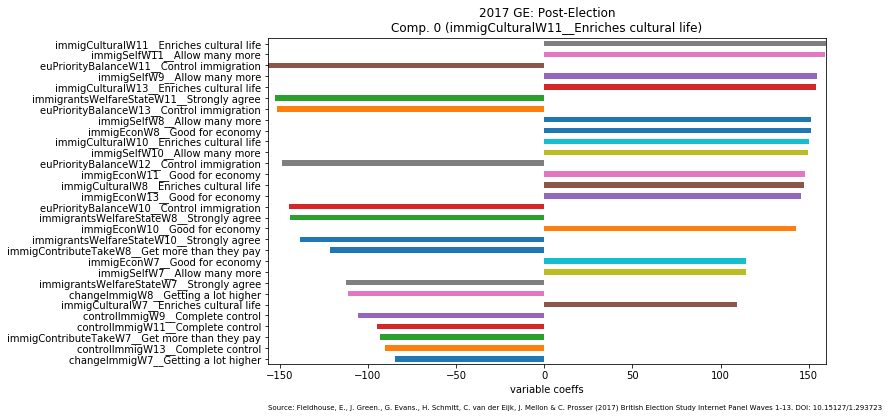

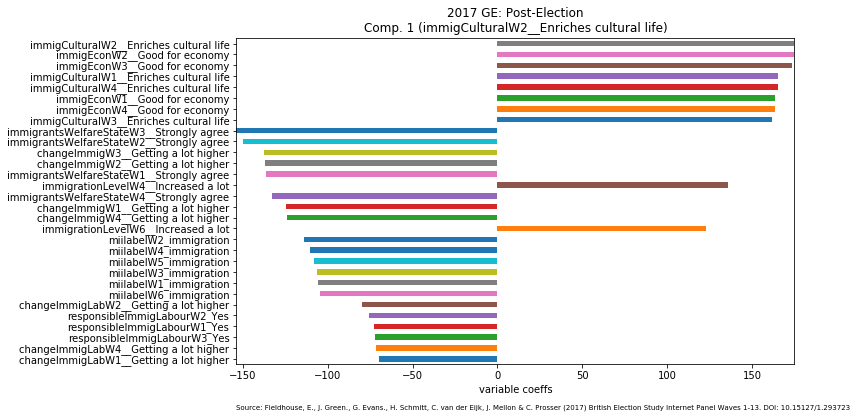

In [19]:
%%time
Treatment = "pan-dataset-values" + "_immigration"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    
    

clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

n_components = BES_std.shape[1]
n_components = 2

#decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp = SparsePCA(n_components = n_components, alpha = 32)
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [20]:
comp_dict[0].sort_values(by='comp_absmag', ascending=False).iloc[0:50]

,components_,comp_absmag
immigCulturalW11__Enriches cultural life,159.785423,159.785423
immigSelfW11__Allow many more,159.350568,159.350568
euPriorityBalanceW11__Control immigration,-156.648431,156.648431
immigSelfW9__Allow many more,154.781529,154.781529
immigCulturalW13__Enriches cultural life,153.990691,153.990691
immigrantsWelfareStateW11__Strongly agree,-152.718276,152.718276
euPriorityBalanceW13__Control immigration,-151.751985,151.751985
immigSelfW8__Allow many more,151.590126,151.590126
immigEconW8__Good for economy,151.234659,151.234659
immigCulturalW10__Enriches cultural life,150.314580,150.314580


In [21]:
# BES_decomp[0].hist(bins=100);
genImmigSentiment = BES_decomp[0].copy()

In [71]:
al_lr_values

['lr2W6__Strongly agree',
 'lr3W6__Strongly agree',
 'lr4W6__Strongly agree',
 'lr5W6__Strongly agree',
 'al1W6__Strongly agree',
 'al2W6__Strongly agree',
 'al3W6__Strongly agree',
 'al4W6__Strongly agree',
 'al5W6__Strongly agree',
 'lr2W13__Strongly agree',
 'lr3W13__Strongly agree',
 'lr4W13__Strongly agree',
 'lr5W13__Strongly agree',
 'al1W13__Strongly agree',
 'al2W13__Strongly agree',
 'al3W13__Strongly agree',
 'al4W13__Strongly agree',
 'al5W13__Strongly agree',
 'lr2W1W2W3W4W5__Strongly agree',
 'lr3W1W2W3W4W5__Strongly agree',
 'lr4W1W2W3W4W5__Strongly agree',
 'lr5W1W2W3W4W5__Strongly agree',
 'al1W1W2W3W4W5__Strongly agree',
 'al2W1W2W3W4W5__Strongly agree',
 'al3W1W2W3W4W5__Strongly agree',
 'al4W1W2W3W4W5__Strongly agree',
 'al5W1W2W3W4W5__Strongly agree',
 'lr2W7W8W9__Strongly agree',
 'lr3W7W8W9__Strongly agree',
 'lr4W7W8W9__Strongly agree',
 'lr5W7W8W9__Strongly agree',
 'al1W7W8W9__Strongly agree',
 'al2W7W8W9__Strongly agree',
 'al3W7W8W9__Strongly agree',
 'al4W7

In [22]:
## Generalised lr/al sentiments

In [62]:
# lr  leftRight, redistSelf, cutsTooFar
# al immigEcon, immigCultural, immigSelf, immigrantsWelfareState, overseasAid
# al_lr_values = [x for x in BES_reduced.columns if re.match("(al|lr)\d|redistSelf",x)]
al_lr_values = [x for x in BES_reduced.columns if re.match("(al\d|lr2|lr3|lr4|lr5)",x)]

                                                           #|govtHandouts|cutsTooFar|immigSelf|immigEcon|immigCultural|immigrantsWelfareState|overseasAid",x)]
BES_vals = BES_reduced[al_lr_values]

In [64]:
Treatment = "pan-dataset-values" + "_allr_values" + "minus_redist"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

Wall time: 3.74 s


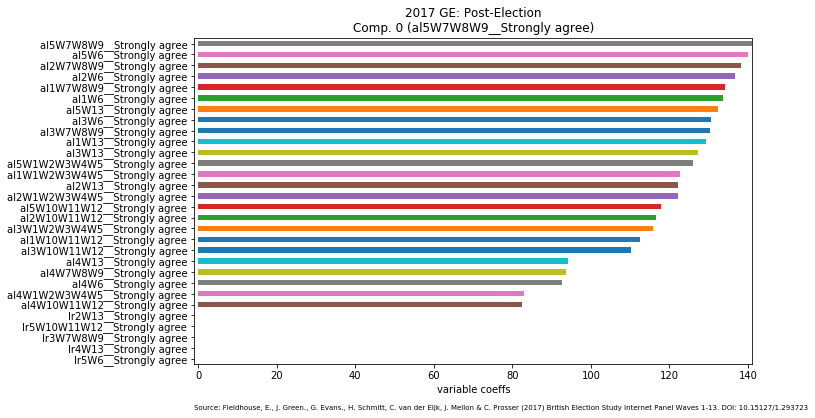

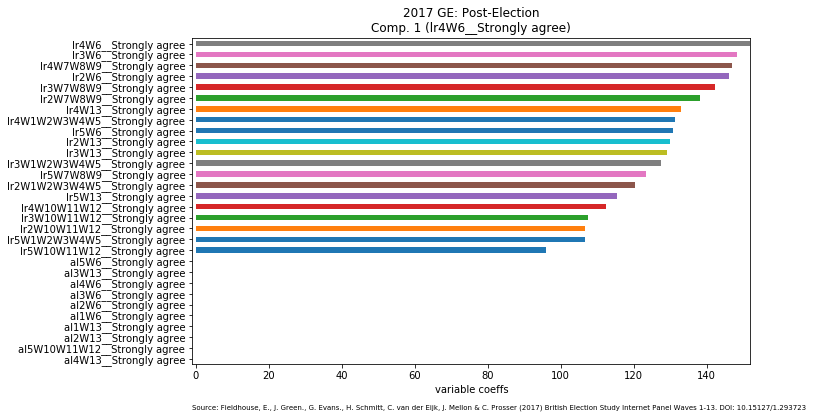

In [65]:
%%time
# normalise data (subtract out the mean, divide through by standard deviation)
BES = BES_vals
clean_feature_set_std = StandardScaler().fit_transform(BES.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES.columns,
                             index   = BES.index      )


# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
# n_components = BES_std.shape[1]
n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = SparsePCA(n_components = n_components, alpha = 32)
#decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [66]:
comp_dict[0].sort_values(by='comp_absmag',ascending=False)

,components_,comp_absmag
al5W7W8W9__Strongly agree,141.117301,141.117301
al5W6__Strongly agree,140.046660,140.046660
al2W7W8W9__Strongly agree,138.211088,138.211088
al2W6__Strongly agree,136.780366,136.780366
al1W7W8W9__Strongly agree,134.224194,134.224194
al1W6__Strongly agree,133.590438,133.590438
al5W13__Strongly agree,132.291758,132.291758
al3W6__Strongly agree,130.498966,130.498966
al3W7W8W9__Strongly agree,130.213080,130.213080
al1W13__Strongly agree,129.202343,129.202343


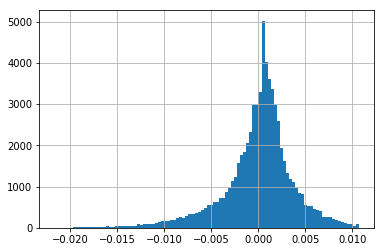

In [67]:
BES_decomp[0].hist(bins=100);

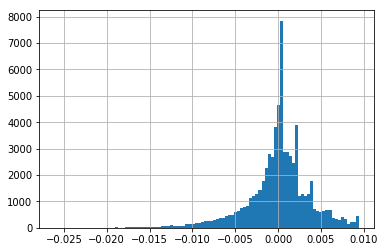

In [70]:
BES_decomp[1].hist(bins=100);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


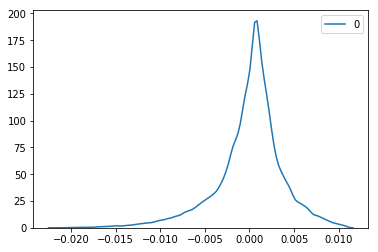

In [68]:
#BES_decomp[0].hist(bins=100)
sns.kdeplot(BES_decomp[0]);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


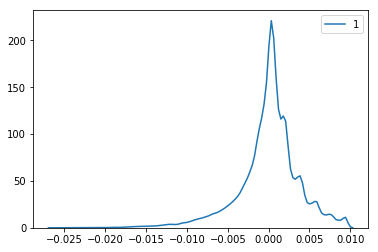

In [69]:
sns.kdeplot(BES_decomp[1]);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


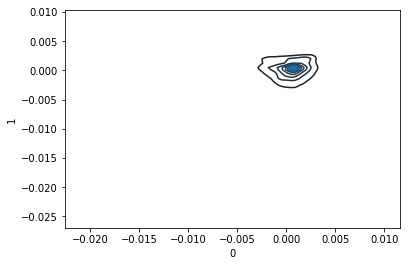

In [72]:
sns.kdeplot(BES_decomp[0],BES_decomp[1]);

In [73]:
raw_gen_lr_vals = BES_decomp[0].copy()
raw_gen_al_vals = BES_decomp[1].copy()


In [74]:
al_corr = BES_reduced.corrwith(BES_decomp[0])
lr_corr = BES_reduced.corrwith(BES_decomp[1])
diff_corr = al_corr.abs()-lr_corr.abs()

# lr  leftRight, redistSelf, cutsTooFar
# al immigEcon, immigCultural, immigSelf, immigrantsWelfareState, overseasAid

In [75]:
diff_corr.drop(al_lr_values).sort_values()

lr_scaleW7W8W9__Right                                                   -0.721232
lr_scaleW6__Right                                                       -0.679563
lr_scaleW1W2W3W4W5__Right                                               -0.663207
lr_scaleW13__Right                                                      -0.608753
lr_scaleW10W11W12__Right                                                -0.591144
polForTheRichW4__Strongly agree                                         -0.449936
polForTheRichW3__Strongly agree                                         -0.414138
polForTheRichW7__Strongly agree                                         -0.400938
lr1W6__Strongly agree                                                   -0.391814
lr1W7W8W9__Strongly agree                                               -0.390845
polForTheRichW1__Strongly agree                                         -0.385647
zeroHourContractW6__Should definitely be legal                          -0.375210
lr1W1W2W3W4W5__S

In [76]:
from scipy import stats

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


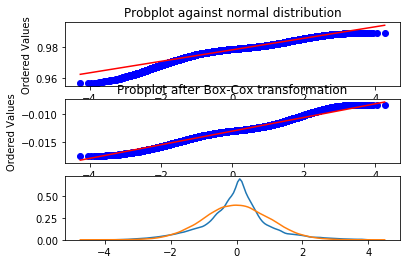

In [77]:
# box cox lr_scale
fig = plt.figure()
ax1 = fig.add_subplot(311)
x = BES_decomp[0].values +BES_decomp[0].values.min()+1
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(312)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
ax3 = fig.add_subplot(313)
xt_std_lr = (xt-xt.mean())/xt.std()
sns.kdeplot(xt_std_lr, ax=ax3);
sns.kdeplot(np.random.normal(size=len(xt_std_lr)), ax=ax3);


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


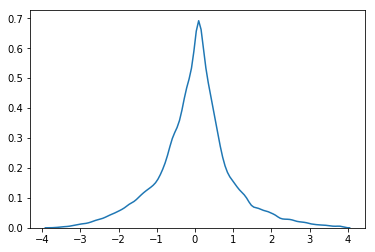

In [78]:
sns.kdeplot(xt_std_lr);

In [79]:
xt_std_lr

array([ 1.60451513, -1.00508187,  0.46218437, ..., -0.30011671,
       -0.00852061, -0.28428786])

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


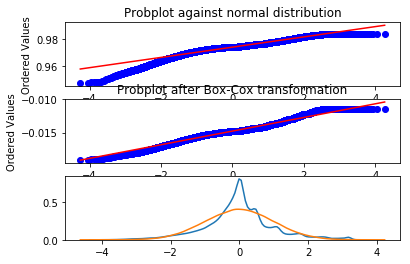

In [80]:
# box cox lr_scale
fig = plt.figure()
ax1 = fig.add_subplot(311)
x = BES_decomp[1].values +BES_decomp[1].values.min()+1
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(312)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
ax3 = fig.add_subplot(313)
xt_std_al = (xt-xt.mean())/xt.std()
sns.kdeplot(xt_std_al, ax=ax3);
sns.kdeplot(np.random.normal(size=len(xt_std_al)), ax=ax3);


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


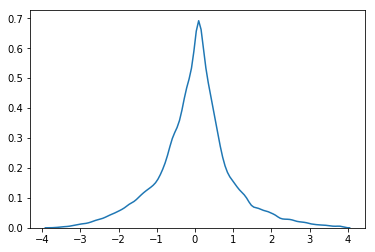

In [81]:
sns.kdeplot(xt_std_lr);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


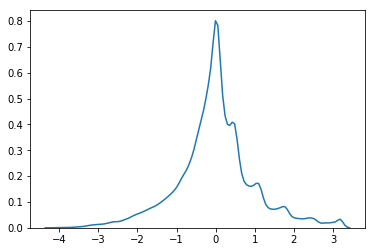

In [82]:
sns.kdeplot(xt_std_al);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


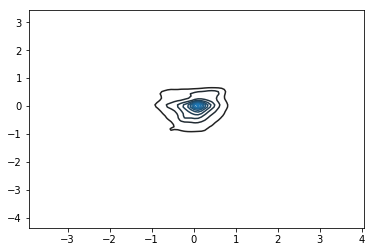

In [83]:
sns.kdeplot(xt_std_lr,xt_std_al);

In [84]:
new_lr_corr = BES_reduced.corrwith(pd.DataFrame(xt_std_lr)[0])

In [85]:
(al_corr-new_lr_corr).sort_values()

conAngryW6_Yes                                                                                                    -0.051157
conAngryW4_Yes                                                                                                    -0.050616
nonelecParticipation_2W6_Yes                                                                                      -0.047827
ldAngryW4_Yes                                                                                                     -0.045028
ldAngryW6_Yes                                                                                                     -0.044104
partyContact1W13_Yes                                                                                              -0.042776
conFearW6_Yes                                                                                                     -0.042109
nonelecParticipation_7W6_Yes                                                                                      -0.042083
ukipAngr

In [109]:
granularity = 50
lr_uniform = pd.qcut( xt_std_lr, q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( xt_std_al, q=granularity, labels=range(0,47), duplicates='drop') #, labels=range(0,granularity-2), duplicates='drop')

In [110]:
al_uniform

[45, 1, 38, 19, 11, ..., 26, 19, 24, 24, 21]
Length: 68625
Categories (47, int64): [0 < 1 < 2 < 3 ... 43 < 44 < 45 < 46]

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


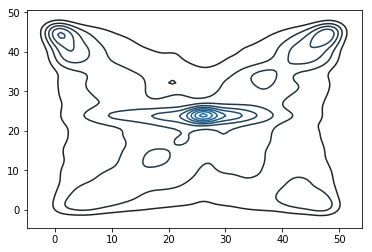

In [111]:
sns.kdeplot(lr_uniform.codes,al_uniform.codes);

In [115]:
# # BES_small_data_files
BES_genImmSentiment = BES_Panel[["id"]].copy()
BES_genImmSentiment["genImmigSentiment"] = genImmigSentiment
BES_genImmSentiment["raw_gen_lr_vals"] = raw_gen_lr_vals
BES_genImmSentiment["raw_gen_al_vals"] = raw_gen_al_vals
BES_genImmSentiment["xt_std_lr"] = xt_std_lr
BES_genImmSentiment["xt_std_al"] = xt_std_al
BES_genImmSentiment["lr_uniform"] = list(lr_uniform)
BES_genImmSentiment["al_uniform"] = list(al_uniform)

# BES_genImmSentiment.to_csv(BES_small_data_files + "pan_dataset_values"+".csv", index=False)

In [117]:
save_original_lr_breakdown

lr1W13__Strongly agree                                                   -0.162786
lr1W6__Strongly agree                                                    -0.150055
lr1W7W8W9__Strongly agree                                                -0.143326
lr1W1W2W3W4W5__Strongly agree                                            -0.125895
lr3W13__Strongly agree                                                   -0.124984
lr1W10W11W12__Strongly agree                                             -0.119531
lr3W6__Strongly agree                                                    -0.099676
lr2W6__Strongly agree                                                    -0.072341
lr3W10W11W12__Strongly agree                                             -0.064104
lr4W6__Strongly agree                                                    -0.063420
lr2W13__Strongly agree                                                   -0.062393
lr4W13__Strongly agree                                                   -0.058760
lr3W

In [112]:
# save_original_lr_breakdown = BES_vals.corrwith(BES_genImmSentiment["raw_gen_al_vals"]).sort_values()
BES_vals.corrwith(BES_genImmSentiment["raw_gen_al_vals"]).sort_values()

lr3W13__Strongly agree          -0.124984
lr3W6__Strongly agree           -0.099676
lr2W6__Strongly agree           -0.072341
lr3W10W11W12__Strongly agree    -0.064104
lr4W6__Strongly agree           -0.063420
lr2W13__Strongly agree          -0.062393
lr4W13__Strongly agree          -0.058760
lr3W7W8W9__Strongly agree       -0.054301
lr3W1W2W3W4W5__Strongly agree   -0.045947
lr2W1W2W3W4W5__Strongly agree   -0.038646
lr2W10W11W12__Strongly agree    -0.037306
lr2W7W8W9__Strongly agree       -0.026813
lr4W10W11W12__Strongly agree    -0.012387
lr4W1W2W3W4W5__Strongly agree   -0.010552
lr4W7W8W9__Strongly agree       -0.008777
lr5W6__Strongly agree            0.037667
lr5W13__Strongly agree           0.037814
lr5W10W11W12__Strongly agree     0.052692
lr5W1W2W3W4W5__Strongly agree    0.062194
lr5W7W8W9__Strongly agree        0.066798
al4W10W11W12__Strongly agree     0.436701
al4W1W2W3W4W5__Strongly agree    0.438972
al4W6__Strongly agree            0.475803
al4W7W8W9__Strongly agree        0

In [116]:
# save_original_corr = BES_genImmSentiment.corr()

BES_genImmSentiment.corr()

,id,genImmigSentiment,raw_gen_lr_vals,raw_gen_al_vals,xt_std_lr,xt_std_al,lr_uniform,al_uniform
id,1.000000,0.008480,0.005591,0.022411,-0.038561,-0.024400,-0.038284,-0.018228
genImmigSentiment,0.008480,1.000000,-0.639397,0.078969,-0.634161,0.079468,-0.588144,0.070250
raw_gen_lr_vals,0.005591,-0.639397,1.000000,-0.047758,0.983507,-0.058976,0.910435,-0.050355
raw_gen_al_vals,0.022411,0.078969,-0.047758,1.000000,-0.015011,0.983410,0.001827,0.913570
xt_std_lr,-0.038561,-0.634161,0.983507,-0.015011,1.000000,-0.015126,0.932684,-0.012677
xt_std_al,-0.024400,0.079468,-0.058976,0.983410,-0.015126,1.000000,0.001349,0.937401
lr_uniform,-0.038284,-0.588144,0.910435,0.001827,0.932684,0.001349,1.000000,0.007590
al_uniform,-0.018228,0.070250,-0.050355,0.913570,-0.012677,0.937401,0.007590,1.000000


In [114]:
save_original_corr

,id,genImmigSentiment,raw_gen_lr_vals,raw_gen_al_vals,xt_std_lr,xt_std_al,lr_uniform,al_uniform
id,1.000000,0.008480,0.062959,0.005591,0.013843,-0.038560,0.019927,-0.038279
genImmigSentiment,0.008480,1.000000,0.166177,-0.639402,0.169042,-0.634166,0.151689,-0.588145
raw_gen_lr_vals,0.062959,0.166177,1.000000,-0.133742,0.985557,-0.105204,0.899755,-0.083027
raw_gen_al_vals,0.005591,-0.639402,-0.133742,1.000000,-0.147759,0.983506,-0.130630,0.910435
xt_std_lr,0.013843,0.169042,0.985557,-0.147759,1.000000,-0.108298,0.919066,-0.085059
xt_std_al,-0.038560,-0.634166,-0.105204,0.983506,-0.108298,1.000000,-0.098758,0.932683
lr_uniform,0.019927,0.151689,0.899755,-0.130630,0.919066,-0.098758,1.000000,-0.078149
al_uniform,-0.038279,-0.588145,-0.083027,0.910435,-0.085059,0.932683,-0.078149,1.000000


In [48]:
## try another approach to Gaussianize a distribution

In [49]:
# ### test gaussianize
# # https://github.com/gregversteeg/gaussianize/blob/master/gaussianize.py
# DID NOT WORK!



# import gaussianize as g

# pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)

# pan_dataset_values["raw_gen_lr_vals"].hist(bins=100)

# out = g.Gaussianize()
# out.fit(pan_dataset_values["raw_gen_lr_vals"])  # Learn the parameters for the transformation
# lr_normed = out.transform(pan_dataset_values["raw_gen_lr_vals"])  # Transform x to y, where y should be normal
# pd.DataFrame(lr_normed).hist(bins=50)

# import gaussianize_2 as g_2

# out = g_2.Gaussianize()
# out.fit(pan_dataset_values["raw_gen_lr_vals"])
# lr_normed = out.transform(pan_dataset_values["raw_gen_lr_vals"])
# x_prime = out.normal_to_observed(lr_normed)  # Recover the initial distribution
# print(np.allclose(x_prime, pan_dataset_values["raw_gen_lr_vals"]))
# pd.DataFrame(lr_normed).hist(bins=50)

# ##### !!! Doens't finish !!!

In [144]:
[x for x in BES_reduced.columns if re.match("lr_scale",x)]

['lr_scaleW7W8W9__Right',
 'lr_scaleW6__Right',
 'lr_scaleW1W2W3W4W5__Right',
 'lr_scaleW10W11W12__Right',
 'lr_scaleW13__Right']

In [155]:
BES_reduced['al_scaleW13__Authoritarian'][~SocialLiberals].mean()

13.758160410352064

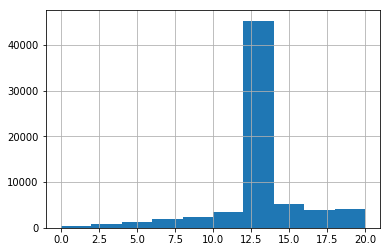

In [152]:
BES_reduced['al_scaleW13__Authoritarian'].hist()

In [ ]:
#######################################################################
###### Left-right for Social Liberals
#######################################################################

In [148]:
BES_genImmSentiment = pd.read_csv(BES_small_data_files + "pan_dataset_values"+".csv")

In [165]:
SocialLiberals      = BES_genImmSentiment['raw_gen_al_vals']<=BES_genImmSentiment['raw_gen_al_vals'].quantile(.25)
SocialConservatives = BES_genImmSentiment['raw_gen_al_vals']>=BES_genImmSentiment['raw_gen_al_vals'].quantile(.75)
# 17242
al_lr_values = [x for x in BES_reduced.columns if re.match("(al|lr)\d|redistSelf",x)]
#al_lr_values = [x for x in BES_reduced.columns if re.match("(al\d|lr2|lr3|lr4|lr5)",x)]

In [191]:
BES_immig = BES_reduced[al_lr_values][SocialLiberals]
# BES_immig = BES_reduced[al_lr_values][SocialConservatives]
lib = False
short = True
if lib==True and short==False:
    BES_immig = BES_reduced[SocialLiberals]
    Treatment = "pan-dataset-values" + "_socialliberals"
else:
    BES_immig = BES_reduced[SocialConservatives]
    Treatment = "pan-dataset-values" + "_socialconservatives"
    
if lib==True and short==True:
    BES_immig = BES_reduced[al_lr_values][SocialLiberals]
    Treatment = "pan-dataset-values" + "_socialliberals_short"
else:
    BES_immig = BES_reduced[al_lr_values][SocialConservatives]
    Treatment = "pan-dataset-values" + "_socialconservatives_short"


BES_immig[BES_immig.columns[BES_immig.isnull().any()]] = \
    BES_immig[BES_immig.columns[BES_immig.isnull().any()]].apply(lambda x: x.fillna(x.mean()))

In [192]:
# temp = BES_Panel[[x for x in BES_Panel.columns if "eumii" in x.lower()]]
# temp2 = (temp == "immigration") | (temp == "Immigration")
# temp3 = temp2.astype('float')
# temp3.columns = [x+"_immigration" for x in temp3.columns]
# eumii_vars = temp3

# temp = BES_Panel[[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]]
# temp2 = (temp == "immigration") | (temp == "Immigration")
# temp3 = temp2.astype('float')
# temp3.columns = [x+"_immigration" for x in temp3.columns]
# mii_vars = temp3

# BES_immig = pd.concat( [ BES_reduced[[x for x in BES_reduced.columns if "imm" in x.lower()]].drop("miilabelW1_immigration",axis=1), eumii_vars, mii_vars], axis=1)
# BES_immig = BES_immig.drop([x for x in BES_immig.columns if "discrim" in x], axis=1)
# # fill NaNs in eumii/mii vars with mean
# BES_immig[BES_immig.columns[BES_immig.isnull().any()]] = \
#     BES_immig[BES_immig.columns[BES_immig.isnull().any()]].apply(lambda x: x.fillna(x.mean()))

Wall time: 3.03 s


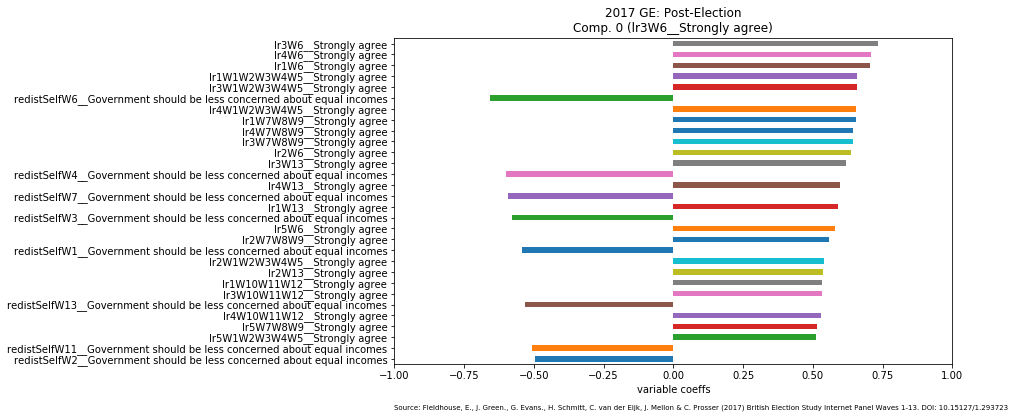

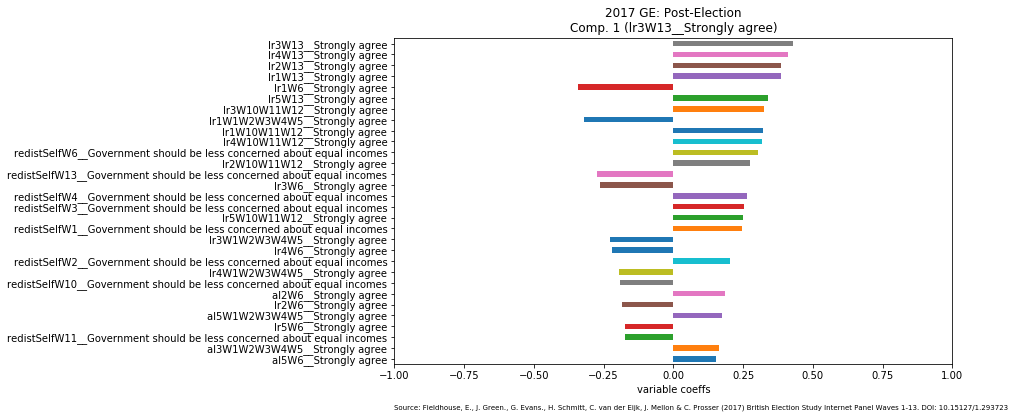

In [193]:
%%time


output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    
    

clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

n_components = BES_std.shape[1]
n_components = 2

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
#decomp = SparsePCA(n_components = n_components, alpha = 32)
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [ ]:
# Well, that was not particularly helpful

In [8]:
BES_genImmSentiment = pd.read_csv(BES_small_data_files + "pan_dataset_values"+".csv")
SocialLiberals      = BES_genImmSentiment['raw_gen_al_vals']<=BES_genImmSentiment['raw_gen_al_vals'].quantile(.25)
SocialConservatives = BES_genImmSentiment['raw_gen_al_vals']>=BES_genImmSentiment['raw_gen_al_vals'].quantile(.75)
# 17242
al_lr_values = [x for x in BES_reduced_with_na.columns if re.match("(al|lr)\d|redistSelf",x)]

In [9]:
al_lr_valuesW13 = [x for x in BES_reduced_with_na.columns if re.match("((al|lr)\d|redistSelf)\w*W13",x)]

In [10]:
al_valuesW13 = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)]

In [11]:
BES_reduced_with_na[al_lr_valuesW13][SocialConservatives].dropna().corr().loc[al_valuesW13].mean()

redistSelfW13__Government should be less concerned about equal incomes   -0.016586
lr1W13__Strongly agree                                                    0.028048
lr2W13__Strongly agree                                                    0.064328
lr3W13__Strongly agree                                                    0.048064
lr4W13__Strongly agree                                                    0.058363
lr5W13__Strongly agree                                                    0.076792
al1W13__Strongly agree                                                    0.323450
al2W13__Strongly agree                                                    0.247718
al3W13__Strongly agree                                                    0.328999
al4W13__Strongly agree                                                    0.216396
al5W13__Strongly agree                                                    0.329005
dtype: float64

In [12]:
BES_reduced_with_na[al_lr_valuesW13][SocialLiberals].dropna().corr().loc[al_valuesW13].mean()

redistSelfW13__Government should be less concerned about equal incomes    0.195166
lr1W13__Strongly agree                                                   -0.201596
lr2W13__Strongly agree                                                   -0.143971
lr3W13__Strongly agree                                                   -0.183392
lr4W13__Strongly agree                                                   -0.141524
lr5W13__Strongly agree                                                   -0.098304
al1W13__Strongly agree                                                    0.439438
al2W13__Strongly agree                                                    0.330912
al3W13__Strongly agree                                                    0.420742
al4W13__Strongly agree                                                    0.370541
al5W13__Strongly agree                                                    0.405166
dtype: float64

In [13]:
SocialSlice      = (BES_genImmSentiment['raw_gen_al_vals']<=BES_genImmSentiment['raw_gen_al_vals'].quantile(.1)) \
                    & (BES_genImmSentiment['raw_gen_al_vals']>=BES_genImmSentiment['raw_gen_al_vals'].quantile(0.0)) 

BES_reduced_with_na[al_lr_valuesW13][SocialSlice].dropna().corr().loc[al_valuesW13].mean()       


redistSelfW13__Government should be less concerned about equal incomes    0.160767
lr1W13__Strongly agree                                                   -0.155767
lr2W13__Strongly agree                                                   -0.110992
lr3W13__Strongly agree                                                   -0.148393
lr4W13__Strongly agree                                                   -0.109878
lr5W13__Strongly agree                                                   -0.077002
al1W13__Strongly agree                                                    0.412672
al2W13__Strongly agree                                                    0.299232
al3W13__Strongly agree                                                    0.396960
al4W13__Strongly agree                                                    0.354877
al5W13__Strongly agree                                                    0.375676
dtype: float64

In [14]:
BES_reduced_with_na[al_lr_valuesW13][SocialLiberals].dropna().var()

redistSelfW13__Government should be less concerned about equal incomes    7.604917
lr1W13__Strongly agree                                                    1.223570
lr2W13__Strongly agree                                                    0.904452
lr3W13__Strongly agree                                                    0.929453
lr4W13__Strongly agree                                                    1.084268
lr5W13__Strongly agree                                                    1.079793
al1W13__Strongly agree                                                    1.001059
al2W13__Strongly agree                                                    1.009075
al3W13__Strongly agree                                                    1.004671
al4W13__Strongly agree                                                    1.120777
al5W13__Strongly agree                                                    0.762334
dtype: float64

In [15]:
BES_reduced_with_na[al_lr_valuesW13][SocialConservatives].dropna().var()

redistSelfW13__Government should be less concerned about equal incomes    11.143916
lr1W13__Strongly agree                                                     1.571809
lr2W13__Strongly agree                                                     0.912194
lr3W13__Strongly agree                                                     1.146192
lr4W13__Strongly agree                                                     1.248605
lr5W13__Strongly agree                                                     0.948679
al1W13__Strongly agree                                                     0.406484
al2W13__Strongly agree                                                     0.806165
al3W13__Strongly agree                                                     0.367372
al4W13__Strongly agree                                                     1.015938
al5W13__Strongly agree                                                     0.339720
dtype: float64

In [16]:
# plt.figure(figsize=(12,8))
# g = sns.violinplot(x='profile_eurefvote_Leave the EU',
#                 y='likeCorbynW13__Strongly like',
#                 hue='generalElectionVoteW13_Labour', data=BES_reduced_with_na, cut=0, bw=.25)

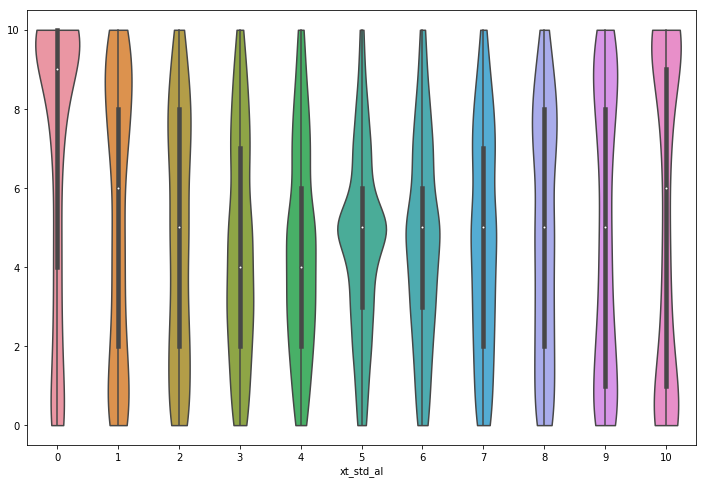

In [17]:
granularity = 11
lr_uniform = pd.qcut( BES_genImmSentiment['xt_std_lr'], q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( BES_genImmSentiment['xt_std_al'], q=granularity, labels=range(0,granularity)) #, labels=range(0,granularity-2), duplicates='drop')
plt.figure(figsize=(12,8))
sns.violinplot(al_uniform, lr_uniform.cat.codes, cut=0, bw=.25);

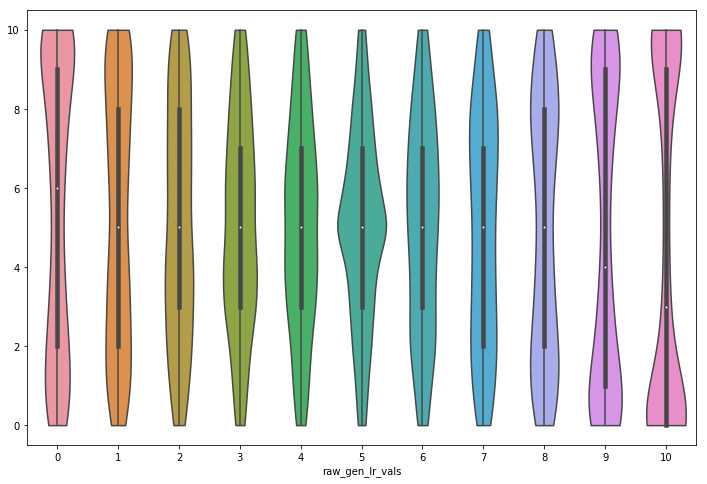

In [18]:
granularity = 11
lr_uniform = pd.qcut( BES_genImmSentiment['raw_gen_lr_vals'], q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( BES_genImmSentiment['raw_gen_al_vals'], q=granularity, labels=range(0,granularity)) #, labels=range(0,granularity-2), duplicates='drop')
plt.figure(figsize=(12,8))
sns.violinplot(lr_uniform, al_uniform.cat.codes, cut=0, bw=.25);

In [91]:
BES_genImmSentiment.head()

,id,genImmigSentiment,raw_gen_lr_vals,raw_gen_al_vals,xt_std_lr,xt_std_al,lr_uniform,al_uniform
0,1,-0.005635,0.006900,0.005395,2.117757,1.604609,48,47
1,2,0.001292,-0.010506,-0.003629,-2.362559,-1.005104,0,6
2,3,0.003045,0.001116,0.001943,0.225521,0.462197,32,37
3,4,0.000170,0.000091,0.001235,-0.061444,0.251536,21,32
4,5,-0.000032,-0.001446,0.000089,-0.467411,-0.073327,12,21


In [83]:
corr_lr = BES_reduced_with_na.corrwith(BES_genImmSentiment['raw_gen_lr_vals'])
corr_al = BES_reduced_with_na.corrwith(BES_genImmSentiment['raw_gen_al_vals'])
corr_im = BES_reduced_with_na.corrwith(BES_genImmSentiment['genImmigSentiment'])

In [85]:
corr_lr.sort_values()

lr_scaleW6__Right                                                        -0.889383
lr_scaleW13__Right                                                       -0.840828
lr_scaleW7W8W9__Right                                                    -0.813902
lr_scaleW1W2W3W4W5__Right                                                -0.785395
lr_scaleW10W11W12__Right                                                 -0.782219
redistSelfW6__Government should be less concerned about equal incomes    -0.729212
redistSelfW3__Government should be less concerned about equal incomes    -0.699893
redistSelfW4__Government should be less concerned about equal incomes    -0.693191
redistSelfW7__Government should be less concerned about equal incomes    -0.692221
redistSelfW13__Government should be less concerned about equal incomes   -0.660526
redistSelfW11__Government should be less concerned about equal incomes   -0.646792
redistSelfW1__Government should be less concerned about equal incomes    -0.641368
redi

In [86]:
corr_al.sort_values()

immigSelfW7__Allow many more                  -0.597744
asylumMoreW13__Many more                      -0.595683
immigSelfW8__Allow many more                  -0.593871
immigSelfW9__Allow many more                  -0.587545
asylumMoreW7__Many more                       -0.586978
asylumMoreW8__Many more                       -0.582097
immigSelfW11__Allow many more                 -0.568835
immigEconW7__Good for economy                 -0.566869
immigEconW3__Good for economy                 -0.566342
immigCulturalW7__Enriches cultural life       -0.562751
immigEconW8__Good for economy                 -0.560902
immigSelfW10__Allow many more                 -0.557920
immigCulturalW3__Enriches cultural life       -0.557780
immigCulturalW8__Enriches cultural life       -0.553242
immigCulturalW13__Enriches cultural life      -0.551894
immigEconW4__Good for economy                 -0.547163
immigCulturalW2__Enriches cultural life       -0.542465
immigEconW2__Good for economy                 -0

In [87]:
corr_im.sort_values()

euPriorityBalanceW11__Control immigration        -0.794756
euPriorityBalanceW13__Control immigration        -0.791487
euPriorityBalanceW10__Control immigration        -0.776277
immigrantsWelfareStateW8__Strongly agree         -0.772673
euPriorityBalanceW12__Control immigration        -0.770661
immigrantsWelfareStateW11__Strongly agree        -0.767041
immigrantsWelfareStateW7__Strongly agree         -0.758758
happyEULeaveW11__Extremely happy                 -0.741846
immigrantsWelfareStateW10__Strongly agree        -0.738500
EUIntegrationSelfW11__Protect our independence   -0.727523
happyEULeaveW9__Extremely happy                  -0.722108
happyEULeaveW10__Extremely happy                 -0.720937
euUndermineIdentityW8__Strongly agree            -0.714964
EUIntegrationSelfW13__Protect our independence   -0.714541
ukCoopMovementW8__Bad for Britain                -0.706519
EUIntegrationSelfW10__Protect our independence   -0.703749
EUIntegrationSelfW9__Protect our independence    -0.7037

In [18]:
# al_lr_valuesW13 = 
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d|redistSelf)\w*W13",x)]

In [19]:
al_uniform.value_counts()

5     6241
4     6240
10    6239
9     6239
7     6239
3     6239
1     6239
0     6239
8     6238
2     6238
6     6234
Name: raw_gen_al_vals, dtype: int64

In [20]:
# sns.violinplot(BES_reduced_with_na[lr_values[0]])


# al_uniform==0

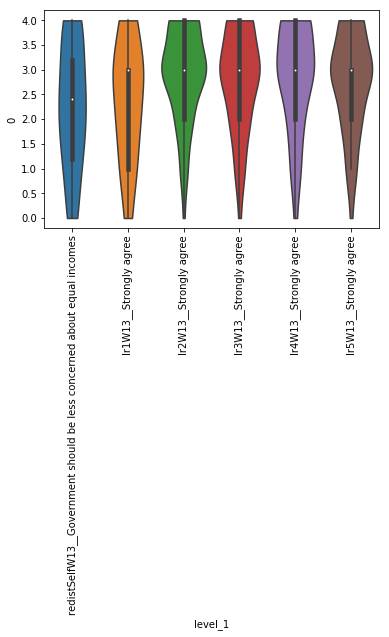

In [21]:
lr_vals = BES_reduced_with_na[lr_values].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

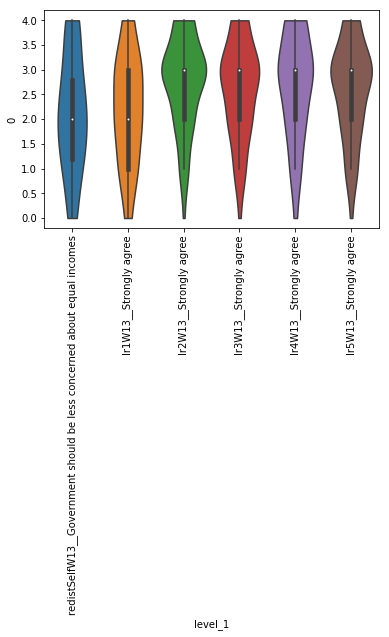

In [22]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==4].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

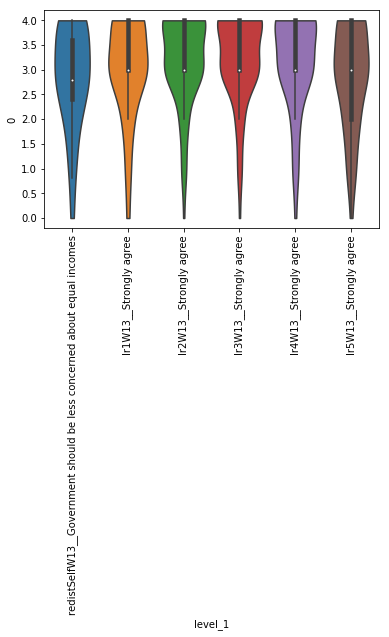

In [23]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==0].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

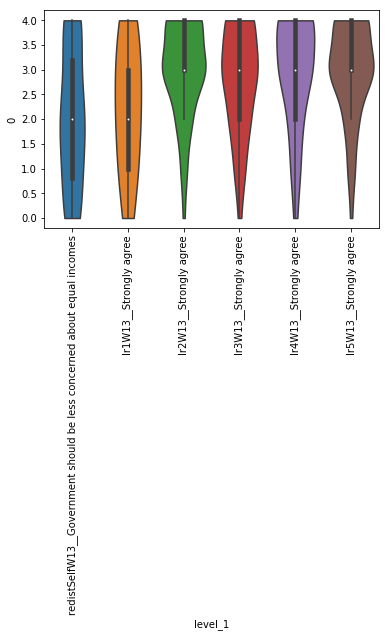

In [24]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==10].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

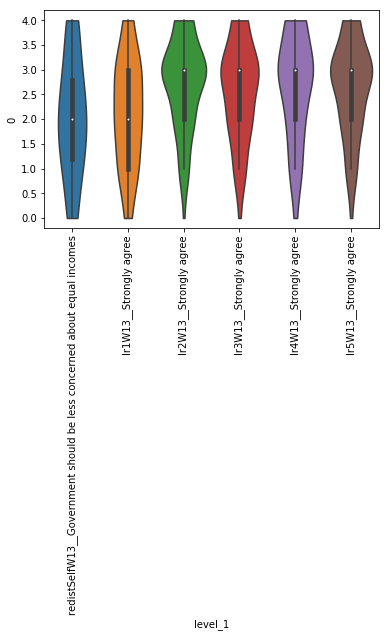

In [25]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==5].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

In [27]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)]
al_vals = BES_reduced_with_na[al_values].copy()
al_mask = al_vals.notnull().all(axis=1)
al_vals = StandardScaler().fit_transform(al_vals[al_mask].values )

al_vals = pd.DataFrame(      al_vals,
                             columns = BES_reduced_with_na[al_values].dropna().columns,
                             index   = BES_reduced_with_na[al_values].dropna().index      )


In [28]:

lr_vals = BES_reduced_with_na[lr_values].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5
lr_mask = lr_vals.notnull().all(axis=1)
lr_vals = StandardScaler().fit_transform(lr_vals[lr_mask].values )

lr_vals = pd.DataFrame(      lr_vals,
                             columns = BES_reduced_with_na[lr_values].dropna().columns,
                             index   = BES_reduced_with_na[lr_values].dropna().index      )

lr_val_names = list(lr_vals.columns)
lr_val_names[0] = lr_val_names[0].replace('Government should be less concerned about equal incomes',
                        'EqualiseIncomes')
lr_vals.columns = lr_val_names
lr_vals.columns

Index(['redistSelfW13__EqualiseIncomes', 'lr1W13__Strongly agree',
       'lr2W13__Strongly agree', 'lr3W13__Strongly agree',
       'lr4W13__Strongly agree', 'lr5W13__Strongly agree'],
      dtype='object')

In [79]:
Treatment = "pan-dataset-values"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

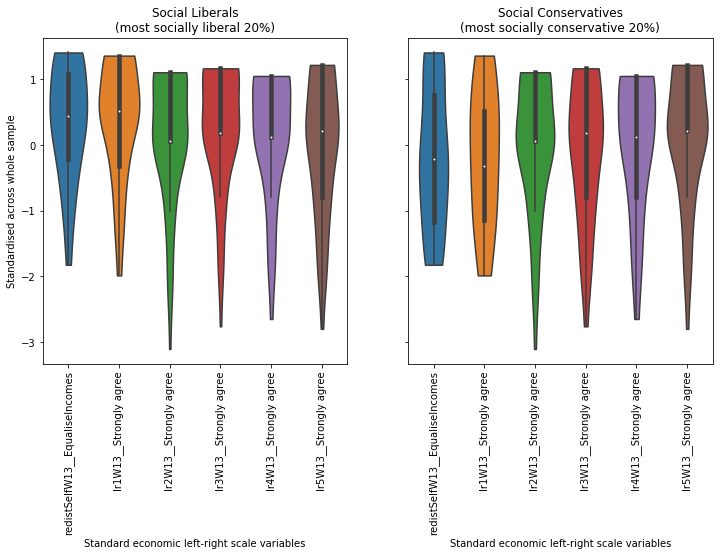

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = lr_vals[(al_uniform<2)[lr_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Standardised across whole sample');
ax1.set_xlabel('Standard economic left-right scale variables');
ax1.set_title("Social Liberals\n(most socially liberal 20%)");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = lr_vals[(al_uniform>8)[lr_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('Standard economic left-right scale variables');
ax2.set_title("Social Conservatives\n(most socially conservative 20%)");
"pan_dataset_values"
plt.savefig(output_subfolder + "something_about_redistribution" + ".png", bbox_inches='tight')

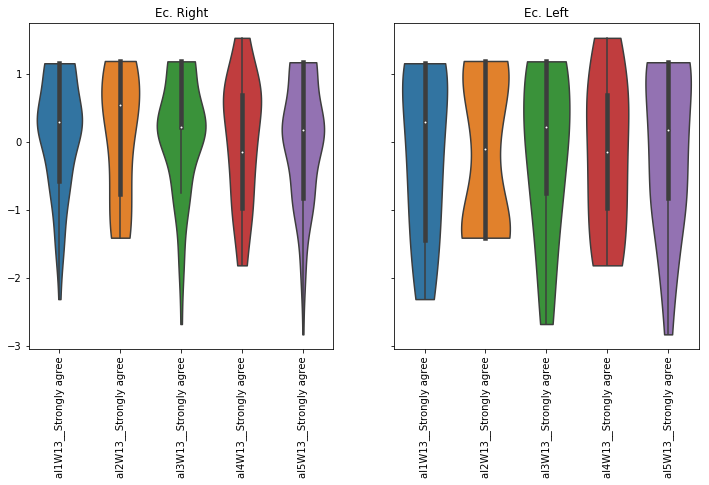

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = al_vals[(lr_uniform<2)[al_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('');
ax1.set_xlabel('');
ax1.set_title("Ec. Right");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = al_vals[(lr_uniform>8)[al_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('');
ax2.set_title("Ec. Left");
plt.savefig(output_subfolder + "something_about_redistribution" + ".png", bbox_inches='tight')

In [ ]:
## redo

In [88]:
# BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if "education" in x]].notnull().sum()

In [64]:
NoUni = BES_reduced_with_na['anyUniW13__Yes, I graduated from higher education']==0.0
SomeUni = BES_reduced_with_na['anyUniW13__Yes, I graduated from higher education']>0

In [97]:
lr_vals[(al_uniform<2)[lr_mask]][NoUni[lr_mask]]

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,redistSelfW13__EqualiseIncomes,lr1W13__Strongly agree,lr2W13__Strongly agree,lr3W13__Strongly agree,lr4W13__Strongly agree,lr5W13__Strongly agree
116,0.438763,1.359369,1.106314,1.166294,1.050053,1.218537
171,-0.529920,0.523735,1.106314,0.185261,1.050053,1.218537
194,1.407446,1.359369,1.106314,1.166294,1.050053,1.218537
215,0.438763,1.359369,1.106314,1.166294,1.050053,1.218537
232,1.084552,0.523735,0.054148,0.185261,0.125978,0.214792
284,-0.852814,-1.983167,0.054148,-2.757836,-1.722174,0.214792
287,-0.852814,-1.147533,-0.998017,-1.776804,-0.798098,-1.792697
422,1.407446,1.359369,1.106314,1.166294,1.050053,1.218537
437,-0.529920,0.523735,0.054148,0.185261,0.125978,0.214792
459,-0.529920,-0.311899,0.054148,-0.795771,-0.798098,0.214792


C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


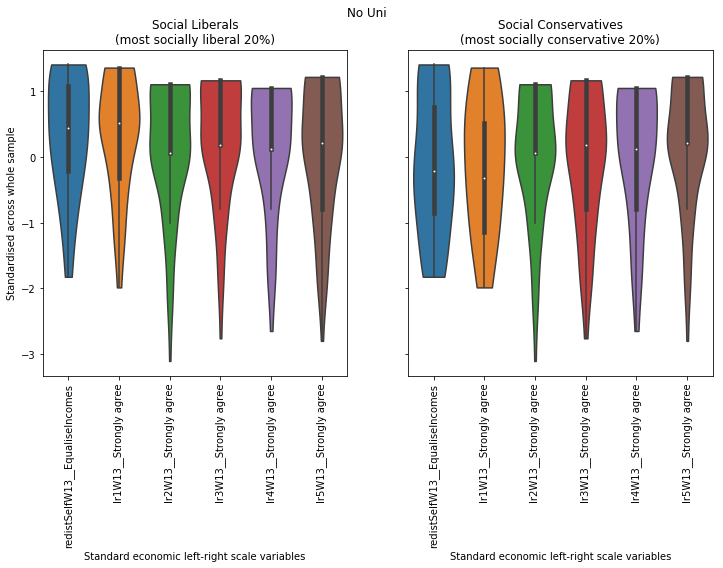

In [94]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = lr_vals[(al_uniform<2)[lr_mask]][NoUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Standardised across whole sample');
ax1.set_xlabel('Standard economic left-right scale variables');
ax1.set_title("Social Liberals\n(most socially liberal 20%)");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = lr_vals[(al_uniform>8)[lr_mask]][NoUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count' )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('Standard economic left-right scale variables');
ax2.set_title("Social Conservatives\n(most socially conservative 20%)");
"pan_dataset_values"
plt.savefig(output_subfolder + "something_about_redistribution_no_uni" + ".png", bbox_inches='tight')
plt.suptitle("No Uni");

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


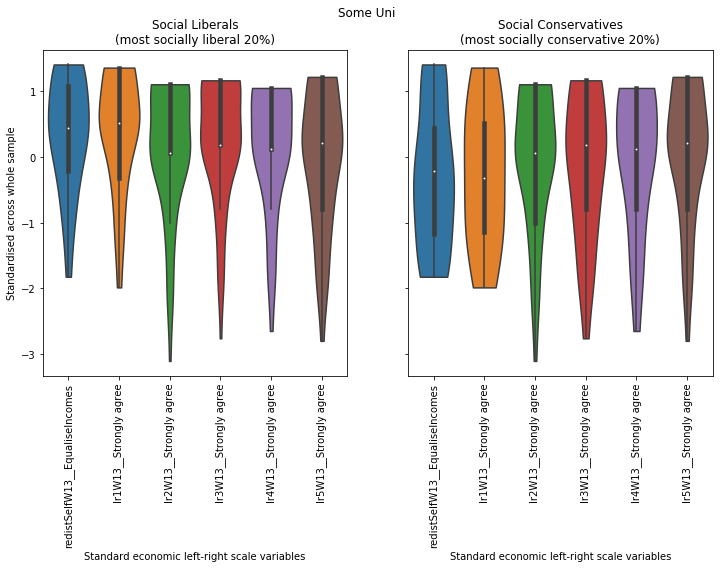

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = lr_vals[(al_uniform<2)[lr_mask]][SomeUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Standardised across whole sample');
ax1.set_xlabel('Standard economic left-right scale variables');
ax1.set_title("Social Liberals\n(most socially liberal 20%)");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = lr_vals[(al_uniform>8)[lr_mask]][SomeUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count' )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('Standard economic left-right scale variables');
ax2.set_title("Social Conservatives\n(most socially conservative 20%)");
"pan_dataset_values"
plt.savefig(output_subfolder + "something_about_redistribution_some_uni" + ".png", bbox_inches='tight')
plt.suptitle("Some Uni");

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


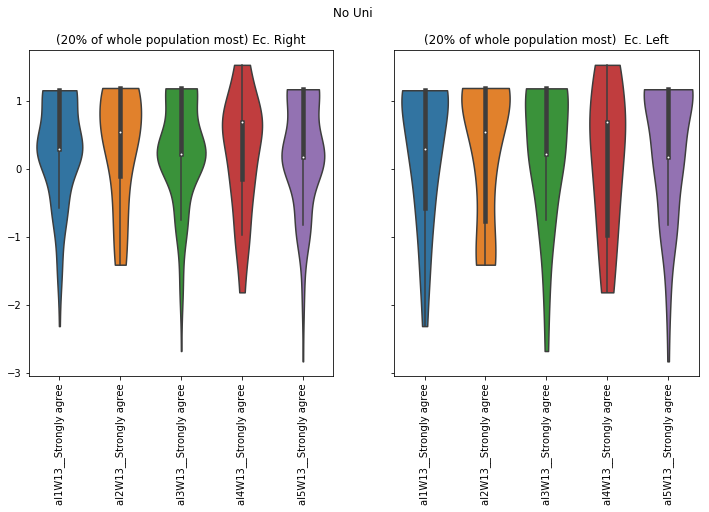

In [100]:



f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = al_vals[(lr_uniform<2)[al_mask]][NoUni[al_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('');
ax1.set_xlabel('');
ax1.set_title("(20% of whole population most) Ec. Right");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = al_vals[(lr_uniform>8)[al_mask]][NoUni[al_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('');
ax2.set_title("(20% of whole population most)  Ec. Left");
plt.suptitle("No Uni");
plt.savefig(output_subfolder + "something_about_redistribution_no_uni_al_vals" + ".png", bbox_inches='tight')

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


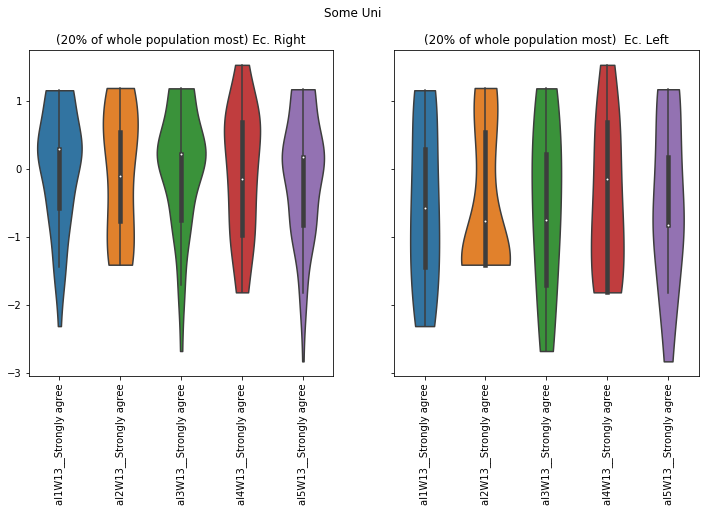

In [101]:

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = al_vals[(lr_uniform<2)[al_mask]][SomeUni[al_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('');
ax1.set_xlabel('');
ax1.set_title("(20% of whole population most) Ec. Right");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = al_vals[(lr_uniform>8)[al_mask]][SomeUni[al_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('');
ax2.set_title("(20% of whole population most)  Ec. Left");
plt.suptitle("Some Uni");
plt.savefig(output_subfolder + "something_about_redistribution_some_uni_al_vals" + ".png", bbox_inches='tight')

In [80]:
lr_vals[(al_uniform<2)[lr_mask]][NoUni[lr_mask]]

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,redistSelfW13__EqualiseIncomes,lr1W13__Strongly agree,lr2W13__Strongly agree,lr3W13__Strongly agree,lr4W13__Strongly agree,lr5W13__Strongly agree
116,0.438763,1.359369,1.106314,1.166294,1.050053,1.218537
171,-0.529920,0.523735,1.106314,0.185261,1.050053,1.218537
194,1.407446,1.359369,1.106314,1.166294,1.050053,1.218537
215,0.438763,1.359369,1.106314,1.166294,1.050053,1.218537
232,1.084552,0.523735,0.054148,0.185261,0.125978,0.214792
284,-0.852814,-1.983167,0.054148,-2.757836,-1.722174,0.214792
287,-0.852814,-1.147533,-0.998017,-1.776804,-0.798098,-1.792697
422,1.407446,1.359369,1.106314,1.166294,1.050053,1.218537
437,-0.529920,0.523735,0.054148,0.185261,0.125978,0.214792
459,-0.529920,-0.311899,0.054148,-0.795771,-0.798098,0.214792


In [99]:
print( BES_reduced_with_na['lr_scaleW13__Right'].corr(BES_reduced_with_na['al_scaleW13__Authoritarian']) )
print( BES_reduced_with_na['lr_scaleW13__Right'][NoUni].corr(BES_reduced_with_na['al_scaleW13__Authoritarian'][NoUni]) )
print( BES_reduced_with_na['lr_scaleW13__Right'][SomeUni].corr(BES_reduced_with_na['al_scaleW13__Authoritarian'][SomeUni])) 

0.121370177157
0.00544567922949
0.204540728795


(0, 20)

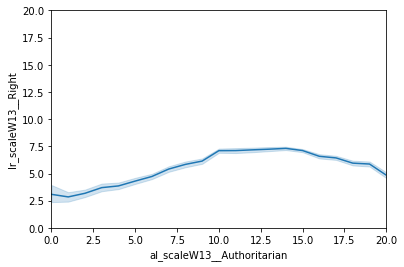

In [30]:
sns.lineplot(x=BES_reduced_with_na['al_scaleW13__Authoritarian'], y=BES_reduced_with_na['lr_scaleW13__Right'])
plt.xlim(0,20);
plt.ylim(0,20);

(0, 20)

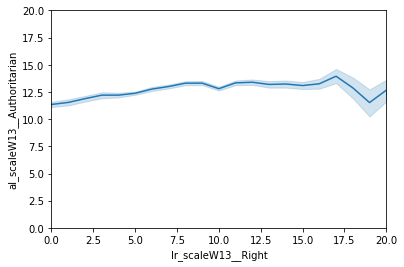

In [31]:
sns.lineplot(y=BES_reduced_with_na['al_scaleW13__Authoritarian'], x=BES_reduced_with_na['lr_scaleW13__Right'])
plt.xlim(0,20);
plt.ylim(0,20);

In [84]:
output_subfolder

'../BES_analysis_output/pan-dataset-values\\'

In [87]:
redistribution_subfolder = output_subfolder + "redistribution" + os.sep

if not os.path.exists( redistribution_subfolder ):
    os.makedirs( redistribution_subfolder )

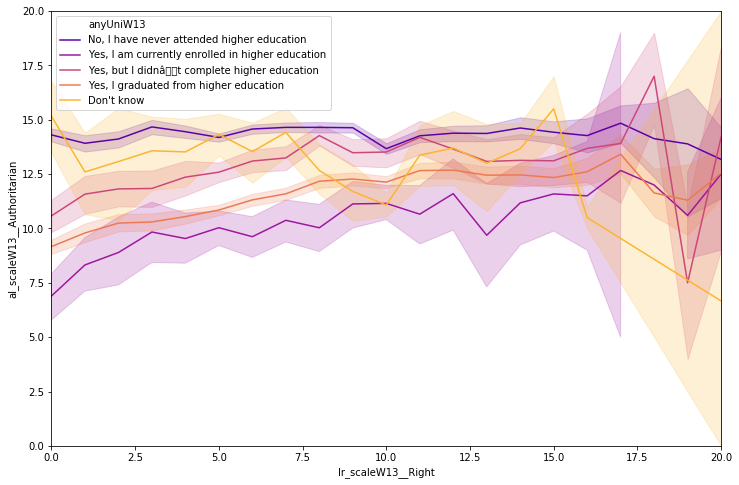

In [88]:
plt.figure(figsize=(12,8))
sns.lineplot(y=BES_reduced_with_na['al_scaleW13__Authoritarian'],
             x=BES_reduced_with_na['lr_scaleW13__Right'],
             hue = BES_Panel['anyUniW13'],
             palette = "plasma")
plt.xlim(0,20);
plt.ylim(0,20);
plt.savefig(redistribution_subfolder + "al_scale_by_lr_scale_by_anyUni" + ".png", bbox_inches='tight')

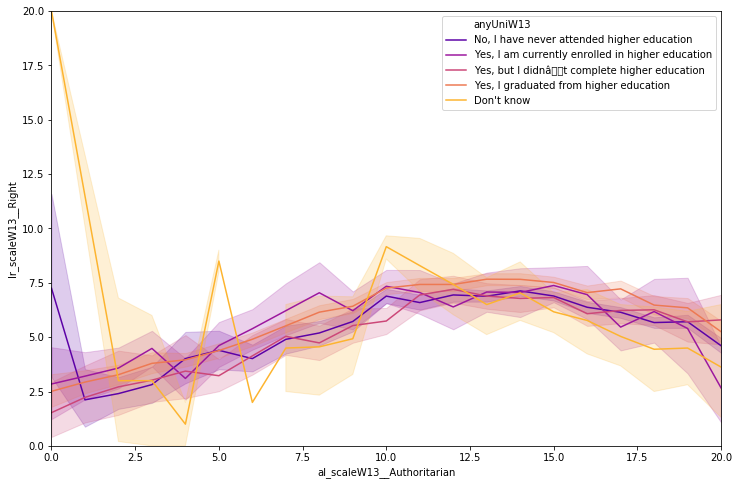

In [89]:
plt.figure(figsize=(12,8))
sns.lineplot(x=BES_reduced_with_na['al_scaleW13__Authoritarian'],
             y=BES_reduced_with_na['lr_scaleW13__Right'],
             hue = BES_Panel['anyUniW13'],
             palette = "plasma")
plt.xlim(0,20);
plt.ylim(0,20);
plt.savefig(redistribution_subfolder + "lr_scale_by_al_scale_by_anyUni" + ".png", bbox_inches='tight')

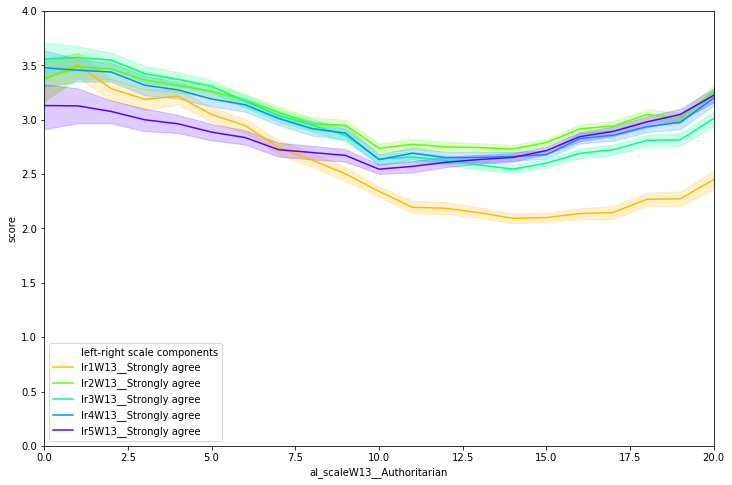

In [90]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d)\w*W13",x)] # |redistSelf

lr_vals_by_al = BES_reduced_with_na[ lr_values + ['al_scaleW13__Authoritarian'] ].copy().set_index('al_scaleW13__Authoritarian').dropna()
lr_vals_by_al = lr_vals_by_al.stack().reset_index()
lr_vals_by_al.columns = ['al_scaleW13__Authoritarian', "left-right scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x='al_scaleW13__Authoritarian',
             hue = "left-right scale components",
             data = lr_vals_by_al,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.ylim(0,4);
plt.savefig(redistribution_subfolder + "lr_vars_by_al_scale" + ".png", bbox_inches='tight')

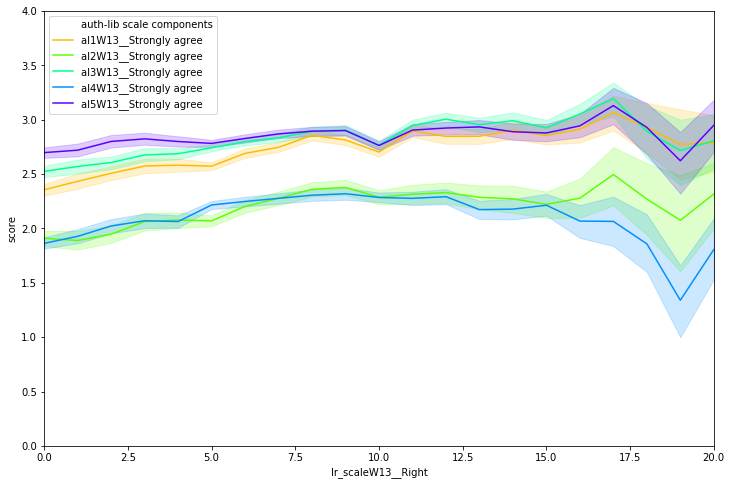

In [91]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)] # |redistSelf
x_scale = 'lr_scaleW13__Right'

al_vals_by_lr = BES_reduced_with_na[ al_values + [x_scale] ].copy().set_index(x_scale).dropna()
al_vals_by_lr = al_vals_by_lr.stack().reset_index()
al_vals_by_lr.columns = [x_scale, "auth-lib scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x=x_scale,
             hue = "auth-lib scale components",
             data = al_vals_by_lr,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.ylim(0,4);
plt.savefig(redistribution_subfolder + "al_vars_by_lr_scale" + ".png", bbox_inches='tight')

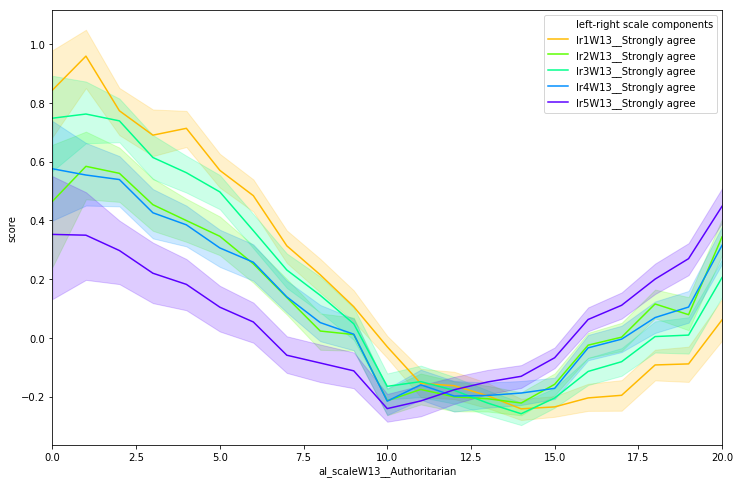

In [92]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d)\w*W13",x)] # |redistSelf

lr_vals_by_al = BES_reduced_with_na[ lr_values + ['al_scaleW13__Authoritarian'] ].copy().set_index('al_scaleW13__Authoritarian').dropna()
# standardise
lr_vals_by_al = (lr_vals_by_al-lr_vals_by_al.mean()) / lr_vals_by_al.std()
lr_vals_by_al = lr_vals_by_al.stack().reset_index()
lr_vals_by_al.columns = ['al_scaleW13__Authoritarian', "left-right scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x='al_scaleW13__Authoritarian',
             hue = "left-right scale components",
             data = lr_vals_by_al,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.savefig(redistribution_subfolder + "lr_vars_by_al_scale_standardised" + ".png", bbox_inches='tight')

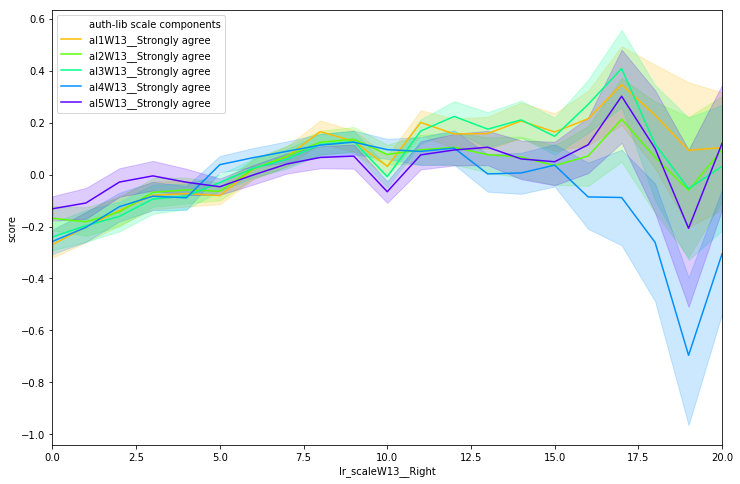

In [93]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)] # |redistSelf
x_scale = 'lr_scaleW13__Right'

al_vals_by_lr = BES_reduced_with_na[ al_values + [x_scale] ].copy().set_index(x_scale).dropna()
# standardise
al_vals_by_lr = (al_vals_by_lr-al_vals_by_lr.mean()) / al_vals_by_lr.std()
al_vals_by_lr = al_vals_by_lr.stack().reset_index()
al_vals_by_lr.columns = [x_scale, "auth-lib scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x=x_scale,
             hue = "auth-lib scale components",
             data = al_vals_by_lr,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.savefig(redistribution_subfolder + "al_vars_by_lr_scale_standardised" + ".png", bbox_inches='tight')

In [9]:
[x for x in BES_reduced_with_na.columns if "likeCorbyn" in x]

['likeCorbynW7__Strongly like',
 'likeCorbynW8__Strongly like',
 'likeCorbynW9__Strongly like',
 'likeCorbynW10__Strongly like',
 'likeCorbynW11__Strongly like',
 'likeCorbynW12__Strongly like',
 'likeCorbynW13__Strongly like']

In [8]:
al_lr_valuesW13 = [x for x in BES_reduced_with_na.columns if re.match("((al|lr)\d|redistSelf)\w*W13",x)]

In [11]:
BES_reduced_with_na[al_lr_valuesW13].corrwith(BES_reduced_with_na['likeCorbynW13__Strongly like'])

redistSelfW13__Government should be less concerned about equal incomes   -0.474530
lr1W13__Strongly agree                                                    0.513140
lr2W13__Strongly agree                                                    0.340690
lr3W13__Strongly agree                                                    0.449882
lr4W13__Strongly agree                                                    0.385982
lr5W13__Strongly agree                                                    0.235041
al1W13__Strongly agree                                                   -0.406568
al2W13__Strongly agree                                                   -0.350803
al3W13__Strongly agree                                                   -0.314817
al4W13__Strongly agree                                                   -0.192230
al5W13__Strongly agree                                                   -0.295960
dtype: float64

['redistSelfW1__Government should be less concerned about equal incomes',
 'redistSelfW2__Government should be less concerned about equal incomes',
 'redistSelfW3__Government should be less concerned about equal incomes',
 'redistSelfW4__Government should be less concerned about equal incomes',
 'redistSelfW6__Government should be less concerned about equal incomes',
 'lr1W6__Strongly agree',
 'redistSelfW7__Government should be less concerned about equal incomes',
 'redistSelfW10__Government should be less concerned about equal incomes',
 'redistSelfW11__Government should be less concerned about equal incomes',
 'redistSelfW13__Government should be less concerned about equal incomes',
 'lr1W13__Strongly agree',
 'lr1W1W2W3W4W5__Strongly agree',
 'lr1W7W8W9__Strongly agree',
 'lr1W10W11W12__Strongly agree']

In [ ]:
### create a redistribution factor

In [15]:
redist_vars = [x for x in BES_reduced_with_na.columns if re.match("((lr1)|redistSelf)\w*",x)]

In [20]:
BES_immig = BES_reduced[redist_vars]

Wall time: 4.12 s


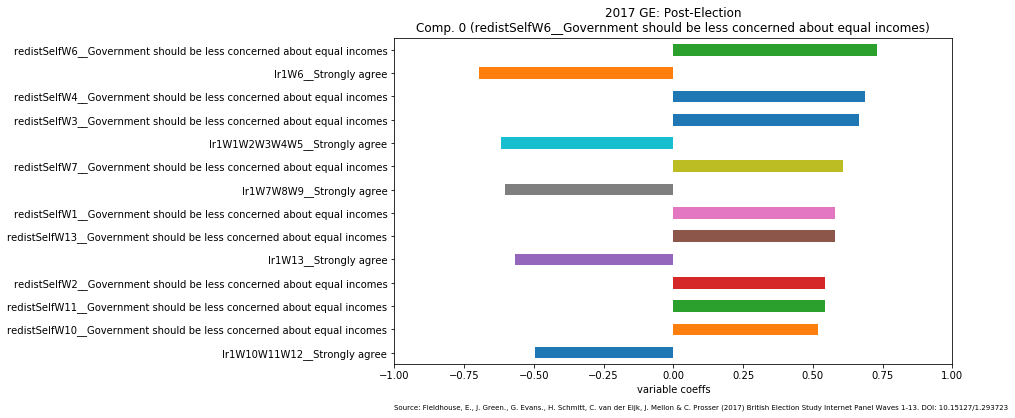

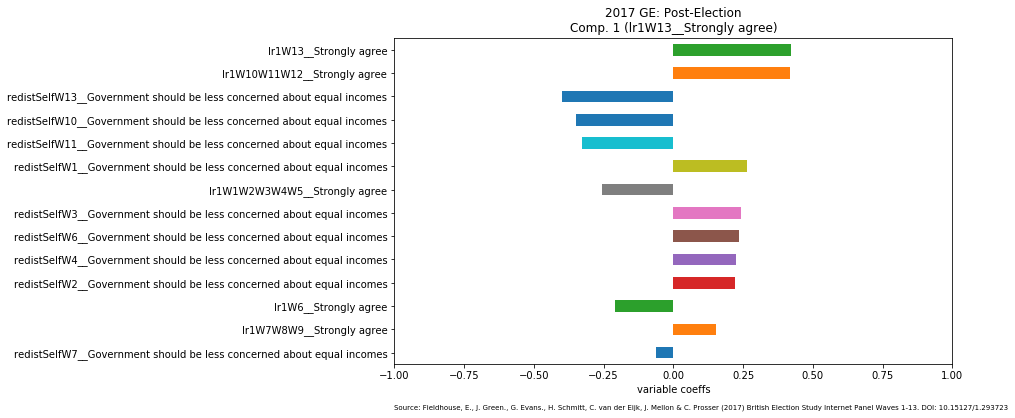

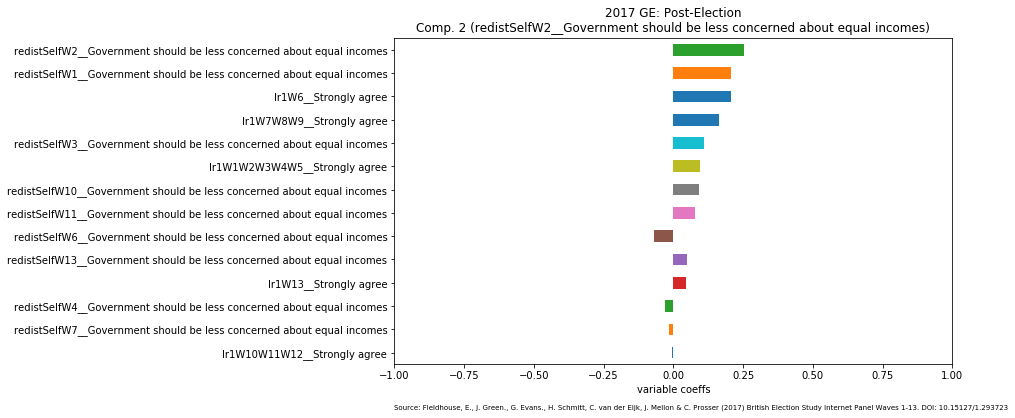

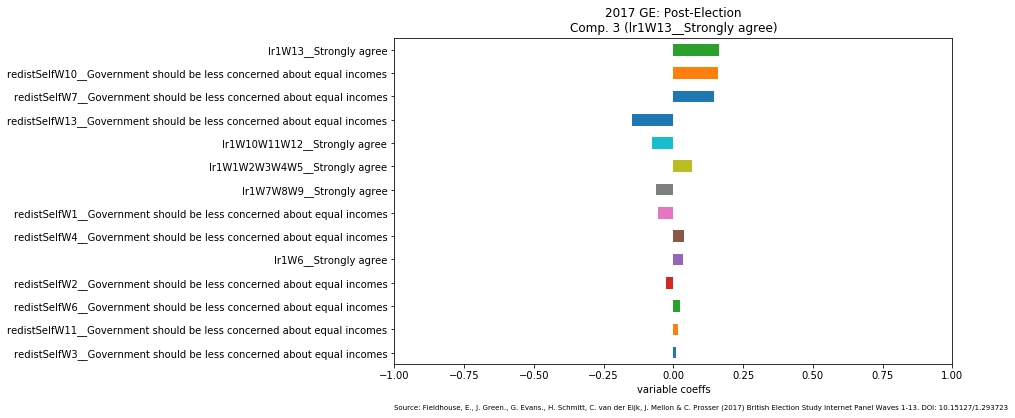

In [25]:
%%time
Treatment = "pan-dataset-values" + "_redistribution"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    
    

clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

n_components = BES_std.shape[1]
# n_components = 2

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
# decomp = SparsePCA(n_components = n_components, alpha = 32)
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [26]:
comp_dict[0].sort_values(by='comp_absmag', ascending=False).iloc[0:50]

,components_,comp_absmag
redistSelfW6__Government should be less concerned about equal incomes,0.730115,0.730115
lr1W6__Strongly agree,-0.696877,0.696877
redistSelfW4__Government should be less concerned about equal incomes,0.688223,0.688223
redistSelfW3__Government should be less concerned about equal incomes,0.663775,0.663775
lr1W1W2W3W4W5__Strongly agree,-0.617651,0.617651
redistSelfW7__Government should be less concerned about equal incomes,0.608289,0.608289
lr1W7W8W9__Strongly agree,-0.602079,0.602079
redistSelfW1__Government should be less concerned about equal incomes,0.580070,0.580070
redistSelfW13__Government should be less concerned about equal incomes,0.579088,0.579088
lr1W13__Strongly agree,-0.567386,0.567386


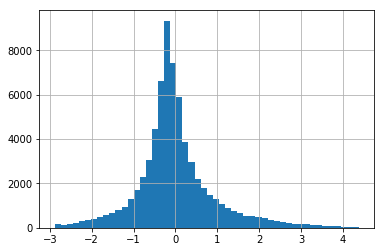

In [33]:
redist = BES_decomp[0]
redist.hist(bins=50);

In [35]:
redist_corr = BES_reduced_with_na.corrwith( redist )

In [37]:
redist_corr.sort_values()

lr1W6__Strongly agree                                                    -0.803647
lr1W13__Strongly agree                                                   -0.739264
lr1W7W8W9__Strongly agree                                                -0.694418
lr1W1W2W3W4W5__Strongly agree                                            -0.691207
lr1W10W11W12__Strongly agree                                             -0.681093
lr3W6__Strongly agree                                                    -0.675056
cutsTooFarNationalW6__Gone much too far                                  -0.615563
lr3W13__Strongly agree                                                   -0.613885
lr4W6__Strongly agree                                                    -0.605100
preferConMajorityW5__Ranked fifth                                        -0.601283
preferConMajorityW4__Ranked fifth                                        -0.595093
cutsTooFarNationalW4__Gone much too far                                  -0.565345
cuts

In [38]:
redist_corr2 = BES_reduced_with_na.corrwith( BES_decomp[1] )


In [39]:
redist_corr2.sort_values()

redistSelfW13__Government should be less concerned about equal incomes   -0.630185
redistSelfW10__Government should be less concerned about equal incomes   -0.589187
redistSelfW11__Government should be less concerned about equal incomes   -0.558766
lr_scaleW13__Right                                                       -0.528070
lr_scaleW10W11W12__Right                                                 -0.514187
lr1W1W2W3W4W5__Strongly agree                                            -0.404300
ptvConW13__Very likely                                                   -0.392760
likeConW13__Strongly like                                                -0.386608
leftRightW13__Right                                                      -0.385958
leftRightW10__Right                                                      -0.371808
ptvConW10__Very likely                                                   -0.368060
likeConW10__Strongly like                                                -0.362476
left

In [41]:
class_war_vars = [x for x in BES_reduced_with_na.columns if re.match("(lr5)\w*",x)]
class_war_vars

['lr5W6__Strongly agree',
 'lr5W13__Strongly agree',
 'lr5W1W2W3W4W5__Strongly agree',
 'lr5W7W8W9__Strongly agree',
 'lr5W10W11W12__Strongly agree']

In [50]:
lr5_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(lr5)\w*",x)]].mean(axis=1)
lr5_gen_corr2 = BES_reduced_with_na.corrwith( lr5_gen )
lr5_gen_corr2.loc[[x for x in lr5_gen_corr2.index if not re.match("lr(\d|_)|redistSelf",x)]].sort_values()

zeroHourContractW6__Should definitely be legal   -0.408236
approveUKGovtW2__Strongly approve                -0.402163
approveUKGovtW4__Strongly approve                -0.399976
approveUKGovtW3__Strongly approve                -0.395034
conGovTrustW5__ Would do a good job              -0.392603
likeCameronW6__Strongly like                     -0.390887
approveUKGovtW1__Strongly approve                -0.389221
handleMIIConW5__Very well                        -0.388488
likeConW8__Strongly like                         -0.386477
likeConW7__Strongly like                         -0.385986
likeCameronW4__Strongly like                     -0.384022
approveUKGovtW7__Strongly approve                -0.381834
ptvConW7__Very likely                            -0.379586
likeCameronW5__Strongly like                     -0.379516
likeCameronW3__Strongly like                     -0.379449
conLookAfterWCW10__Very closely                  -0.376259
changeEconomyW3__Getting a lot better            -0.3741

In [51]:
lr5_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(lr1)\w*",x)]].mean(axis=1)
lr5_gen_corr2 = BES_reduced_with_na.corrwith( lr5_gen )
lr5_gen_corr2.loc[[x for x in lr5_gen_corr2.index if not re.match("lr(\d|_)|redistSelf",x)]].sort_values()

leftRightW6__Right                          -0.591557
conGovTrustW5__ Would do a good job         -0.591004
leftRightW5__Right                          -0.583865
ptvConW7__Very likely                       -0.573144
likeCameronW6__Strongly like                -0.572201
ptvConW9__Very likely                       -0.571272
likeConW7__Strongly like                    -0.570605
leftRightW3__Right                          -0.570129
ptvConW13__Very likely                      -0.568532
leftRightW7__Right                          -0.566870
leftRightW13__Right                         -0.566696
likeConW8__Strongly like                    -0.566665
likeConW9__Strongly like                    -0.561837
leftRightW11__Right                         -0.556845
likeConW13__Strongly like                   -0.556072
leftRightW12__Right                         -0.555876
leftRightW4__Right                          -0.555600
likeCameronW5__Strongly like                -0.555017
handleMIIConW5__Very well   

In [56]:
lr5_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(leftRight)\w*",x)]].mean(axis=1)
lr5_gen_corr2 = BES_reduced_with_na.corrwith( lr5_gen )
# lr5_gen_corr2.loc[[x for x in lr5_gen_corr2.index if not re.match("lr(\d|_)|redistSelf",x)]].sort_values()
# lr5_gen_corr2.sort_values()

lr5_gen_corr2.loc[al_lr_valuesW13].sort_values()


# no big differences over time!

lr1W13__Strongly agree                                                   -0.553592
lr3W13__Strongly agree                                                   -0.489992
lr4W13__Strongly agree                                                   -0.424980
lr2W13__Strongly agree                                                   -0.386177
lr5W13__Strongly agree                                                   -0.270792
al4W13__Strongly agree                                                    0.288484
al5W13__Strongly agree                                                    0.376901
al3W13__Strongly agree                                                    0.404911
al2W13__Strongly agree                                                    0.440050
al1W13__Strongly agree                                                    0.470999
redistSelfW13__Government should be less concerned about equal incomes    0.543395
dtype: float64

In [ ]:
### Englishness and Britishness twitter comment

In [66]:
England_only = BES_Panel["country"]=="England"

englishness_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(english)\w*",x)]][England_only].mean(axis=1)
englishness_gen_corr2 = BES_reduced_with_na.corrwith( englishness_gen )

englishness_gen_corr2.sort_values().dropna()

immigSelfW9__Allow many more                     -0.434475
immigSelfW7__Allow many more                     -0.429170
immigSelfW8__Allow many more                     -0.425942
immigSelfW10__Allow many more                    -0.421895
immigSelfW11__Allow many more                    -0.419137
immigCulturalW3__Enriches cultural life          -0.413548
immigEconW3__Good for economy                    -0.413169
immigCulturalW8__Enriches cultural life          -0.402939
immigEconW8__Good for economy                    -0.399785
immigCulturalW2__Enriches cultural life          -0.398026
immigCulturalW7__Enriches cultural life          -0.397973
immigCulturalW13__Enriches cultural life         -0.396686
immigEconW7__Good for economy                    -0.396390
immigEconW2__Good for economy                    -0.393618
likeSturgeonW11__Strongly like                   -0.390093
immigEconW4__Good for economy                    -0.390050
immigCulturalW10__Enriches cultural life         -0.3885

In [65]:
englishness_gen_corr2.loc[al_lr_valuesW13].sort_values()

lr1W13__Strongly agree                                                   -0.175810
lr3W13__Strongly agree                                                   -0.134382
lr2W13__Strongly agree                                                   -0.109052
lr4W13__Strongly agree                                                   -0.098864
lr5W13__Strongly agree                                                   -0.036209
redistSelfW13__Government should be less concerned about equal incomes    0.175493
al4W13__Strongly agree                                                    0.268635
al5W13__Strongly agree                                                    0.317463
al3W13__Strongly agree                                                    0.322407
al2W13__Strongly agree                                                    0.328420
al1W13__Strongly agree                                                    0.369595
dtype: float64

In [68]:
England_only = BES_Panel["country"]=="England"

britishness_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(british)\w*",x)]][England_only].mean(axis=1)
britishness_gen_corr2 = BES_reduced_with_na.corrwith( britishness_gen )

britishness_gen_corr2.sort_values().dropna()

profile_ethnicity_Any other white background                                                                       -0.331691
profile_ethnicityW12_Any other white background                                                                    -0.318358
passportOtherW9_Yes                                                                                                -0.275636
bestPMW12_Jeremy Corbyn                                                                                            -0.263031
immigSelfW10__Allow many more                                                                                      -0.245529
immigSelfW11__Allow many more                                                                                      -0.234458
likeSturgeonW11__Strongly like                                                                                     -0.231335
likeSNPW12__Strongly like                                                                                          -0.227998


In [69]:
britishness_gen_corr2.loc[al_lr_valuesW13].sort_values()

lr3W13__Strongly agree                                                   -0.123098
lr1W13__Strongly agree                                                   -0.120541
lr4W13__Strongly agree                                                   -0.118070
lr2W13__Strongly agree                                                   -0.115637
lr5W13__Strongly agree                                                   -0.081999
redistSelfW13__Government should be less concerned about equal incomes    0.124570
al2W13__Strongly agree                                                    0.157575
al5W13__Strongly agree                                                    0.182371
al4W13__Strongly agree                                                    0.212372
al1W13__Strongly agree                                                    0.217864
al3W13__Strongly agree                                                    0.222256
dtype: float64